Manga Recommender System
- Yazeed Almuqwishi
- Omar Mohammed

This is our approach for recommender system with MyAnimeList (manga only). We understood the data first, and cleaned it and applied an Item-based approach towards recommending manga to the the user.\
There were a lot of people who done a recommendation system for anime on MyAnimeList, but none on manga specifically, and that got us intrigued. The final result of our system is a prompt that asks for the username of MyAnimeList, and shows recommendations based on the manga list you have on MyAnimeList with their respective link to MyAnimeList. To achieve that, we scrape the mangalist of the the user and input it to our recommendation algorithem\

In [1]:
import pandas as pd
import numpy as np
import scipy
import re
from bs4 import BeautifulSoup
import requests
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import *
from surprise.model_selection import cross_validate
import collections
from statistics import mean 
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting

To talk a bit about the dataset, we got it from https://www.kaggle.com/noraabdull/myanimellist-mangas. While the dataset and was biased towards entries with higher rating, we still think it did a decent job integrated with our recommendation system. For some reason, the dataset entries had a lot of mistakes. Sometimes it would have a column value that's supposed to be in another column and the same goes for rows. Unfortunately, this is the only dataset with manga entries from MyAnimelist, and by the time we started analyzing the data it was too late to start scraping. 

In [2]:
manga_df = pd.read_csv('manga_items_final.csv')
manga_df.head()

,Unnamed: 0,manga_name,manga_link,volumes,chapters,status,genres,authors,serialization,members,favorite,score,rank,popularity,published
0,0,Berserk,https://myanimelist.net/manga/2/Berserk,Unknown,Unknown,Publishing,"Action, Adventure, Demons, Drama, Fantasy, Hor...","Miura, Kentarou (Story & Art)",Young Animal,"241,511","51,860",9.311,12,4,"Aug 25, 1989 to ?"
1,1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,https://myanimelist.net/manga/1706/JoJo_no_Kim...,24,96,Finished,"Action, Adventure, Mystery, Historical, Horror...","Araki, Hirohiko (Story & Art)",Ultra Jump,"62,146","11,695",9.181,22,81,"Jan 19, 2004 to Apr 19, 2011"
2,2,Fullmetal Alchemist,https://myanimelist.net/manga/25/Fullmetal_Alc...,27,116,Finished,"Action, Adventure, Comedy, Drama, Shounen, Mil...","Arakawa, Hiromu (Story & Art)",Shounen Gangan,"174,721","24,532",9.131,32,11,"Jul 12, 2001 to Sep 11, 2010"
3,3,One Piece,https://myanimelist.net/manga/13/One_Piece,Unknown,Unknown,Publishing,"Action, Adventure, Comedy, Fantasy, Shounen, S...","Oda, Eiichiro (Story & Art)",Shounen Jump (Weekly),"255,244","61,615",9.081,42,3,"Jul 22, 1997 to ?"
4,4,Monster,https://myanimelist.net/manga/1/Monster,18,162,Finished,"Mystery, Drama, Psychological, Seinen","Urasawa, Naoki (Story & Art)",Big Comic Original,"83,821","8,436",9.041,52,48,"Dec 5, 1994 to Dec 20, 2001"


The data set has 2550 samples and 15 features. However, the number of features will be reduced only the essential features for recommendations. The key features are the manga name, and the link to manga on MyAnimeList, genres of the manga, the author and artist of the manga,  serilaization (publishers), how many users favorited the manga, the mean score for the manga (0 to 10), 

# 3: Data cleaning

First, we dropped the unnecessary columns to recommending and they are not relevant to the system we will be working on. Columns such as rank and popularity are dependent on score, therefore it doesn't benefit us much since we have score.Also, we dropped any rows with NaN values in it. Fortuntely, there was not a lot. Lastly, the manga entries with indices 1927 and 726 were scraped incorrectly for some reason, so we droppped them manually. I believe there are many samples that were scraped incorrectly, but we will ignore them unless they are too grave since they are harder to detect without manual checking.

In [3]:
# Remove uneeded columns
manga_df = manga_df[["manga_name", "manga_link", "genres", "authors", "serialization", "favorite", "score"]]
manga_df = manga_df.dropna() # drop na columns
# Drop problamtic IDS
problmatic_manga_ids = [1927, 726] 
manga_df.drop(problmatic_manga_ids,inplace=True)

Also, as part of our data cleaning, we extracted the manga id from the manga link, and we will use it below as an index to match between the user and the manga entries.

In [4]:
def extract_manga_id_from_link(links):
    if type(links) == str:
        return re.split(r'\/(\d+)\/', links)[1]
    else:
        return links.str.extract(r'\/(\d+)\/')
manga_df["manga_id"] = extract_manga_id_from_link(manga_df["manga_link"]) # Extract Manga ID from link and add it to a new column
manga_df["manga_id"] = manga_df["manga_id"].astype('int32')
manga_df.head()

,manga_name,manga_link,genres,authors,serialization,favorite,score,manga_id
0,Berserk,https://myanimelist.net/manga/2/Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...","Miura, Kentarou (Story & Art)",Young Animal,"51,860",9.311,2
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,https://myanimelist.net/manga/1706/JoJo_no_Kim...,"Action, Adventure, Mystery, Historical, Horror...","Araki, Hirohiko (Story & Art)",Ultra Jump,"11,695",9.181,1706
2,Fullmetal Alchemist,https://myanimelist.net/manga/25/Fullmetal_Alc...,"Action, Adventure, Comedy, Drama, Shounen, Mil...","Arakawa, Hiromu (Story & Art)",Shounen Gangan,"24,532",9.131,25
3,One Piece,https://myanimelist.net/manga/13/One_Piece,"Action, Adventure, Comedy, Fantasy, Shounen, S...","Oda, Eiichiro (Story & Art)",Shounen Jump (Weekly),"61,615",9.081,13
4,Monster,https://myanimelist.net/manga/1/Monster,"Mystery, Drama, Psychological, Seinen","Urasawa, Naoki (Story & Art)",Big Comic Original,"8,436",9.041,1


Also, as part of our data cleaning, we extracted the author and artist of a manga entry from "authors" column. Although our regex is not perfect, but it captures most of what we wanted it to. 

In [5]:
# Seperate authors into author and artist
manga_df["artist"] = manga_df["authors"].str.extract(r',?([\w\s,]+(?=\((?:Story & )?Art\)))')
manga_df["author"] = manga_df["authors"].str.extract(r"([\w\s,]+?(?=\(Story(?: & Art)?\)))")
manga_df.dropna(inplace=True)
# Get rid of authors
manga_df = manga_df.drop(["authors"], axis=1)

We made sure of our columns' types. favorite is strictly an integer since it represents number of users who favorited the manga

In [6]:
# Make sure that the type of columns are correct
manga_df["favorite"] = manga_df["favorite"].str.replace(',', '').astype('int32')
manga_df["artist"] = manga_df["artist"].astype(str)
manga_df["author"] = manga_df["author"].astype(str)

As we can see in the plot below, predicting score based soley on number of favorites might not be a good idea, but instead it should be combined with other factors to sort of stablizie it. 

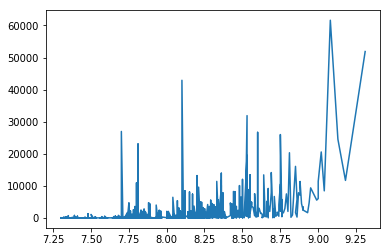

In [7]:
plt.plot(manga_df["score"], manga_df["favorite"] )

Manga id's are generated the moments an entry is inputted into MyAnimeList, and the older entries will have a smaller IDs; therefore, it is not feasible to use manga ids as a predictor in any way. Manga ID should only be used for identififcation purposes

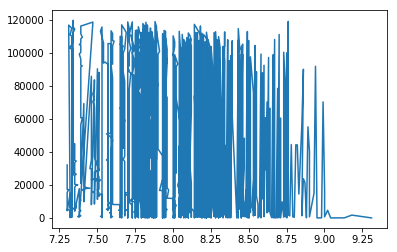

In [8]:
plt.plot( manga_df["score"],manga_df["manga_id"])

I do not believe there is much to gain by plotting. It seems the best way is to dive deep into the recommendation algorithem and test it for ourselves

Make the value of score and favorite between 0 and 1 for easier integration into the recommendation algorithm. 

In [9]:
# Normalize here
manga_df["score"] /= manga_df["score"].max() # Normalize mean score
manga_df["favorite"] /= manga_df["favorite"].max() # Normalize number of people who favorite

In [10]:
manga_df.corr()

,favorite,score,manga_id
favorite,1.000000,0.351068,-0.065055
score,0.351068,1.000000,-0.009950
manga_id,-0.065055,-0.009950,1.000000


It seems that there's weak correlation between score, and favorite column

In the following cell, we are setting up our columns genres, serialization, artist, and author to be combined into one single column, and we will run CountVectorizer on it, and obtain cosine similairty of each item to all other items

In [11]:
# Set up string columns for combining
manga_df["genres"] = manga_df["genres"].apply(lambda x: x.lower().replace(',','').strip())
manga_df['serialization'] = manga_df['serialization'].apply(lambda x: x.lower().replace(' ', ''))
manga_df["artist"] = manga_df["artist"].apply(lambda x: x.lower().replace(',', '').replace(' ', ''))
manga_df["author"] = manga_df["author"].apply(lambda x: x.lower().replace(',', '').replace(' ', ''))
manga_df

,manga_name,manga_link,genres,serialization,favorite,score,manga_id,artist,author
0,Berserk,https://myanimelist.net/manga/2/Berserk,action adventure demons drama fantasy horror s...,younganimal,0.841678,1.000000,2,miurakentarou,miurakentarou
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,https://myanimelist.net/manga/1706/JoJo_no_Kim...,action adventure mystery historical horror sho...,ultrajump,0.189808,0.986038,1706,arakihirohiko,arakihirohiko
2,Fullmetal Alchemist,https://myanimelist.net/manga/25/Fullmetal_Alc...,action adventure comedy drama shounen military,shounengangan,0.398150,0.980668,25,arakawahiromu,arakawahiromu
3,One Piece,https://myanimelist.net/manga/13/One_Piece,action adventure comedy fantasy shounen super ...,shounenjump(weekly),1.000000,0.975298,13,odaeiichiro,odaeiichiro
4,Monster,https://myanimelist.net/manga/1/Monster,mystery drama psychological seinen,bigcomicoriginal,0.136915,0.971002,1,urasawanaoki,urasawanaoki
...,...,...,...,...,...,...,...,...,...
2545,Katakoi Drops,https://myanimelist.net/manga/28153/Katakoi_Drops,romance school shoujo,betsucomi,0.000016,0.784126,28153,konnorisa,konnorisa
2546,Let's Fight Ghost,https://myanimelist.net/manga/28527/Lets_Fight...,action adventure romance shounen supernatural,naverwebtoon,0.000049,0.784126,28527,iminsu,iminsu
2547,Tomodachi Gokko,https://myanimelist.net/manga/30083/Tomodachi_...,drama school shoujo,dessert,0.000049,0.784126,30083,momochireiko,momochireiko
2548,Cloud,https://myanimelist.net/manga/31909/Cloud,seinen,comicbunch,0.000081,0.784126,31909,noujoujunichi,noujoujunichi


bag_of_words will hold our combination.

In [12]:
# Create a new column (bag of words that will hold the combination genres, serialization, artist, and author)

manga_df["bag_of_words"] = manga_df["genres"] + " " + manga_df["serialization"] + " " + manga_df["artist"] + " "+manga_df["author"]
manga_df["bag_of_words"] = manga_df["bag_of_words"].str.strip()
manga_df.drop(["genres", "serialization", "artist", "author"], axis=1, inplace=True)
manga_df

,manga_name,manga_link,favorite,score,manga_id,bag_of_words
0,Berserk,https://myanimelist.net/manga/2/Berserk,0.841678,1.000000,2,action adventure demons drama fantasy horror s...
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Run,https://myanimelist.net/manga/1706/JoJo_no_Kim...,0.189808,0.986038,1706,action adventure mystery historical horror sho...
2,Fullmetal Alchemist,https://myanimelist.net/manga/25/Fullmetal_Alc...,0.398150,0.980668,25,action adventure comedy drama shounen military...
3,One Piece,https://myanimelist.net/manga/13/One_Piece,1.000000,0.975298,13,action adventure comedy fantasy shounen super ...
4,Monster,https://myanimelist.net/manga/1/Monster,0.136915,0.971002,1,mystery drama psychological seinen bigcomicori...
...,...,...,...,...,...,...
2545,Katakoi Drops,https://myanimelist.net/manga/28153/Katakoi_Drops,0.000016,0.784126,28153,romance school shoujo betsucomi konnorisa konn...
2546,Let's Fight Ghost,https://myanimelist.net/manga/28527/Lets_Fight...,0.000049,0.784126,28527,action adventure romance shounen supernatural ...
2547,Tomodachi Gokko,https://myanimelist.net/manga/30083/Tomodachi_...,0.000049,0.784126,30083,drama school shoujo dessert momochireiko momoc...
2548,Cloud,https://myanimelist.net/manga/31909/Cloud,0.000081,0.784126,31909,seinen comicbunch noujoujunichi noujoujunichi


In the following cell, we obtained the cosine simlarity of each item to other item based on bag_of_words, which as demonstrated above, contain genre, artist, author, and serialization

In [13]:
count_matrix = CountVectorizer().fit_transform(manga_df["bag_of_words"])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.2981424 , 0.31139958, ..., 0.09128709, 0.10540926,
        0.25819889],
       [0.2981424 , 1.        , 0.26111648, ..., 0.        , 0.        ,
        0.28867513],
       [0.31139958, 0.26111648, 1.        , ..., 0.10660036, 0.        ,
        0.40201513],
       ...,
       [0.09128709, 0.        , 0.10660036, ..., 1.        , 0.        ,
        0.        ],
       [0.10540926, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.25819889, 0.28867513, 0.40201513, ..., 0.        , 0.        ,
        1.        ]])

Over here, we are asking the user to input his/her username in MyanimeList, and after that the program will scrape the manga list that is contained under the username, and store it in a dataframe. If a rating is missing, it is filled with the mean of rating of the user.The dataframe is passed to the recommendation engine, and will output 10 recommendations that the user is most likely to enjoy

In [14]:
def get_user_rating(tr):
    score = tr.select('span[class*="score-label"]')
    if score is None or score[0].text == "-":
        return np.nan
    else:
        return score[0].text

def df_of_user(username):
    # Scrape user manga list
    # TODO also scrape the status of manga (currently reading, completed, dropped)
    data = {'user_id':1,'username': username, 'manga_name':[], 'manga_id': [],'user_rating':[]}
    r = requests.get("https://myanimelist.net/mangalist/" + username)
    soup = BeautifulSoup(r.text, 'html.parser')
    for tr in soup.find_all('tr'):
        if not tr.find_all(class_="animetitle"):
            # Skip this row. It has no scores
            continue
        manga_name = tr.find("span").get_text()
        manga_score = get_user_rating(tr)
        manga_id = extract_manga_id_from_link(tr.find_all(class_="animetitle")[0]['href'])
        
        data['manga_name'].append(manga_name)
        data['manga_id'].append(int(manga_id))
        data['user_rating'].append(float(manga_score))
        
    df = pd.DataFrame(data=data)
    df['manga_id'] = df['manga_id'].astype('int32')
    df['user_rating'].fillna(df['user_rating'].mean(),inplace=True)
    
    return df

def get_manga_indices_from_user(user_df):
    user_ids_in_manga_df = []
    for index, row in user_df.iterrows():
        if row["manga_id"] in manga_df["manga_id"]:
            user_ids_in_manga_df.append(manga_df[manga_df["manga_id"] == row["manga_id"]].index[0])
    return user_ids_in_manga_df

Formula for calculating predicted score of a manga:
$$score = score + \text_{cosine_simlarity[item_manga][user_manga]} * \text_{user_rating[user_manga]} + \text_{item_manga["favorite"]} * \text_{item_manga["score"]}$$

After the predicted scores are calculated, they are normalized, and multiplied by 10 (To follow MyAnimeList rating), and shown as a dataframe as below.

In [15]:
def get_recommendation_sorted(user_df):
    new_scores = {}
    user_ids_in_manga_df = get_manga_indices_from_user(user_df)
    for user_manga_id, user_row in user_df.iterrows():
        if user_row["manga_id"] not in manga_df["manga_id"]:
            continue
        translate_user_id = manga_df[manga_df["manga_id"] == user_row["manga_id"]].index[0]
        for item_manga_index, item_manga_row in manga_df.iterrows():
            if item_manga_index in user_ids_in_manga_df or user_row["manga_id"] == item_manga_row["manga_id"] or item_manga_index >= len(cosine_sim):
                continue
            
            new_scores[item_manga_index] = new_scores.get(item_manga_index, 0) + ((cosine_sim[item_manga_index][translate_user_id] * user_row['user_rating']))\
            * item_manga_row["score"] * item_manga_row["favorite"]
    mean_score = mean(new_scores.values())
    new_scores = {manga_index: score - mean_score for manga_index, score in new_scores.items()}
    max_score = max(new_scores.values())
    new_scores = {manga_index: score / max_score for manga_index, score in new_scores.items()}
    new_scores = sorted(new_scores.items(), key=lambda kv: kv[1], reverse=True)
    return new_scores
def recommend(mal_username, n_recommendations = 10):
    user_df = df_of_user(mal_username)
    user_df['user_rating'] /= user_df['user_rating'].max() # Normalize user rating
    recommendations = np.array(get_recommendation_sorted(user_df))
    recommendations = recommendations[:n_recommendations]
    recom_df = manga_df.iloc[recommendations[:,0]][["manga_name", "manga_link"]]
    recom_df["predicted_score"] = recommendations[:,1] * 10
    return recom_df
    


In [16]:
recommend('conan-edw') # Recommend you a new manga based on your MyAnimeList username

,manga_name,manga_link,predicted_score
121,Boku no Hero Academia,https://myanimelist.net/manga/75989/Boku_no_He...,10.000000
660,Kuma Kuma Kuma Bear,https://myanimelist.net/manga/100512/Kuma_Kuma...,9.399634
2,Fullmetal Alchemist,https://myanimelist.net/manga/25/Fullmetal_Alc...,9.076895
5,Oyasumi Punpun,https://myanimelist.net/manga/4632/Oyasumi_Punpun,7.239411
1680,Shoujo Kakumei Utena,https://myanimelist.net/manga/26103/Shoujo_Kak...,6.845495
124,Umineko no Naku Koro ni Chiru - Episode 5: End...,https://myanimelist.net/manga/21498/Umineko_no...,5.853361
26,One Punch-Man,https://myanimelist.net/manga/44347/One_Punch-Man,5.344296
119,Hinamatsuri,https://myanimelist.net/manga/36413/Hinamatsuri,4.943517
91,Otoyomegatari,https://myanimelist.net/manga/11514/Otoyomegatari,4.903114
23,Koe no Katachi,https://myanimelist.net/manga/56805/Koe_no_Kat...,3.783125


The username we inputted above belongs to one of our friends, and we asked him whether he thinks our recommender results are good or not, and he said he watched most of those already, and he thought a lot of them deserved a higher result. However, we believe that to be the issue of the dataset, since it is very small (only ~2400 samples) and has many mistakes. We tried our best to them up but we expect a few to have passed through.

One of the things we learned is implementing a recommendation engine from the scratch; albeit, a very small one, but we think it did a good job with this recommendation. In the future, we would like to scrape MyAnimeList ourselves and obtain more data, as we believe there were a lot of valuable information that were missed such as users reviews. Most of the problems were within the database, and if we started with scraping early on, we believe we would've acquired a better predictions. 